In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_05_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1972301, 828)
(1972301, 8)
validation
(232170, 828)
(232170, 8)
test
(287409, 828)
(287409, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/198 [..............................] - ETA: 4:30 - loss: 2.1921 - STD: 0.0613 - MAE: 0.2190

  4/198 [..............................] - ETA: 3s - loss: 2.1022 - STD: 0.0525 - MAE: 0.2166  

  8/198 [>.............................] - ETA: 3s - loss: 2.0882 - STD: 0.0473 - MAE: 0.2166

 11/198 [>.............................] - ETA: 3s - loss: 2.0790 - STD: 0.0433 - MAE: 0.2166

 14/198 [=>............................] - ETA: 3s - loss: 2.0729 - STD: 0.0417 - MAE: 0.2166

 17/198 [=>............................] - ETA: 3s - loss: 2.0690 - STD: 0.0403 - MAE: 0.2166

 20/198 [==>...........................] - ETA: 3s - loss: 2.0650 - STD: 0.0385 - MAE: 0.2166

 23/198 [==>...........................] - ETA: 3s - loss: 2.0608 - STD: 0.0378 - MAE: 0.2165

 27/198 [===>..........................] - ETA: 2s - loss: 2.0540 - STD: 0.0378 - MAE: 0.2163

 30/198 [===>..........................] - ETA: 2s - loss: 2.0474 - STD: 0.0381 - MAE: 0.2160

 34/198 [====>.........................] - ETA: 5s - loss: 2.0380 - STD: 0.0394 - MAE: 0.2155

 37/198 [====>.........................] - ETA: 5s - loss: 2.0279 - STD: 0.0411 - MAE: 0.2150

 40/198 [=====>........................] - ETA: 5s - loss: 2.0175 - STD: 0.0433 - MAE: 0.2144

 43/198 [=====>........................] - ETA: 4s - loss: 2.0072 - STD: 0.0454 - MAE: 0.2138

 46/198 [=====>........................] - ETA: 4s - loss: 1.9964 - STD: 0.0474 - MAE: 0.2132

 49/198 [======>.......................] - ETA: 4s - loss: 1.9851 - STD: 0.0493 - MAE: 0.2127

 52/198 [======>.......................] - ETA: 4s - loss: 1.9731 - STD: 0.0512 - MAE: 0.2120

 55/198 [=======>......................] - ETA: 4s - loss: 1.9607 - STD: 0.0532 - MAE: 0.2114

 58/198 [=======>......................] - ETA: 3s - loss: 1.9474 - STD: 0.0553 - MAE: 0.2107

 61/198 [========>.....................] - ETA: 3s - loss: 1.9336 - STD: 0.0574 - MAE: 0.2099

 64/198 [========>.....................] - ETA: 3s - loss: 1.9193 - STD: 0.0595 - MAE: 0.2091

 67/198 [=========>....................] - ETA: 3s - loss: 1.9050 - STD: 0.0618 - MAE: 0.2083

 70/198 [=========>....................] - ETA: 3s - loss: 1.8902 - STD: 0.0640 - MAE: 0.2075

 73/198 [==========>...................] - ETA: 3s - loss: 1.8758 - STD: 0.0662 - MAE: 0.2067

 76/198 [==========>...................] - ETA: 3s - loss: 1.8622 - STD: 0.0684 - MAE: 0.2058

 79/198 [==========>...................] - ETA: 3s - loss: 1.8494 - STD: 0.0706 - MAE: 0.2050

 82/198 [===========>..................] - ETA: 2s - loss: 1.8371 - STD: 0.0727 - MAE: 0.2042

 85/198 [===========>..................] - ETA: 2s - loss: 1.8252 - STD: 0.0748 - MAE: 0.2035

 88/198 [============>.................] - ETA: 2s - loss: 1.8138 - STD: 0.0767 - MAE: 0.2027

 91/198 [============>.................] - ETA: 2s - loss: 1.8030 - STD: 0.0786 - MAE: 0.2020

 94/198 [=============>................] - ETA: 2s - loss: 1.7925 - STD: 0.0804 - MAE: 0.2013

 97/198 [=============>................] - ETA: 2s - loss: 1.7823 - STD: 0.0820 - MAE: 0.2006

100/198 [==============>...............] - ETA: 2s - loss: 1.7727 - STD: 0.0835 - MAE: 0.2000

103/198 [==============>...............] - ETA: 2s - loss: 1.7634 - STD: 0.0851 - MAE: 0.1994

106/198 [===============>..............] - ETA: 2s - loss: 1.7543 - STD: 0.0866 - MAE: 0.1988

109/198 [===============>..............] - ETA: 2s - loss: 1.7454 - STD: 0.0881 - MAE: 0.1981

112/198 [===============>..............] - ETA: 1s - loss: 1.7371 - STD: 0.0895 - MAE: 0.1976

115/198 [================>.............] - ETA: 1s - loss: 1.7289 - STD: 0.0908 - MAE: 0.1970

118/198 [================>.............] - ETA: 1s - loss: 1.7208 - STD: 0.0921 - MAE: 0.1965

121/198 [=================>............] - ETA: 1s - loss: 1.7132 - STD: 0.0934 - MAE: 0.1959

124/198 [=================>............] - ETA: 1s - loss: 1.7058 - STD: 0.0946 - MAE: 0.1954

127/198 [==================>...........] - ETA: 1s - loss: 1.6984 - STD: 0.0958 - MAE: 0.1949

130/198 [==================>...........] - ETA: 1s - loss: 1.6913 - STD: 0.0970 - MAE: 0.1943

133/198 [===================>..........] - ETA: 1s - loss: 1.6842 - STD: 0.0981 - MAE: 0.1938

136/198 [===================>..........] - ETA: 1s - loss: 1.6773 - STD: 0.0993 - MAE: 0.1933

139/198 [====================>.........] - ETA: 1s - loss: 1.6706 - STD: 0.1004 - MAE: 0.1929

142/198 [====================>.........] - ETA: 1s - loss: 1.6651 - STD: 0.1015 - MAE: 0.1924

145/198 [====================>.........] - ETA: 1s - loss: 1.6593 - STD: 0.1026 - MAE: 0.1919

148/198 [=====================>........] - ETA: 1s - loss: 1.6534 - STD: 0.1036 - MAE: 0.1915

151/198 [=====================>........] - ETA: 1s - loss: 1.6475 - STD: 0.1046 - MAE: 0.1910

154/198 [======================>.......] - ETA: 0s - loss: 1.6417 - STD: 0.1056 - MAE: 0.1906

157/198 [======================>.......] - ETA: 0s - loss: 1.6360 - STD: 0.1065 - MAE: 0.1901

160/198 [=======================>......] - ETA: 0s - loss: 1.6304 - STD: 0.1074 - MAE: 0.1897

163/198 [=======================>......] - ETA: 0s - loss: 1.6250 - STD: 0.1083 - MAE: 0.1893

166/198 [========================>.....] - ETA: 0s - loss: 1.6198 - STD: 0.1092 - MAE: 0.1889

169/198 [========================>.....] - ETA: 0s - loss: 1.6145 - STD: 0.1101 - MAE: 0.1885

172/198 [=========================>....] - ETA: 0s - loss: 1.6094 - STD: 0.1110 - MAE: 0.1880

175/198 [=========================>....] - ETA: 0s - loss: 1.6042 - STD: 0.1119 - MAE: 0.1876

178/198 [=========================>....] - ETA: 0s - loss: 1.5993 - STD: 0.1127 - MAE: 0.1872

181/198 [==========================>...] - ETA: 0s - loss: 1.5945 - STD: 0.1135 - MAE: 0.1869

184/198 [==========================>...] - ETA: 0s - loss: 1.5896 - STD: 0.1143 - MAE: 0.1865

187/198 [===========================>..] - ETA: 0s - loss: 1.5849 - STD: 0.1151 - MAE: 0.1861

190/198 [===========================>..] - ETA: 0s - loss: 1.5803 - STD: 0.1159 - MAE: 0.1857

193/198 [============================>.] - ETA: 0s - loss: 1.5760 - STD: 0.1167 - MAE: 0.1853

196/198 [============================>.] - ETA: 0s - loss: 1.5716 - STD: 0.1175 - MAE: 0.1850

198/198 [==============================] - 6s 26ms/step - loss: 1.5687 - STD: 0.1180 - MAE: 0.1847 - val_loss: 1.2812 - val_STD: 0.1630 - val_MAE: 0.1615


Epoch 2/10000


  1/198 [..............................] - ETA: 10s - loss: 1.2848 - STD: 0.1675 - MAE: 0.1608

  4/198 [..............................] - ETA: 3s - loss: 1.2850 - STD: 0.1673 - MAE: 0.1607 

  7/198 [>.............................] - ETA: 3s - loss: 1.2845 - STD: 0.1674 - MAE: 0.1607

 10/198 [>.............................] - ETA: 3s - loss: 1.2860 - STD: 0.1673 - MAE: 0.1609

 14/198 [=>............................] - ETA: 3s - loss: 1.2823 - STD: 0.1676 - MAE: 0.1606

 17/198 [=>............................] - ETA: 3s - loss: 1.2799 - STD: 0.1679 - MAE: 0.1603

 20/198 [==>...........................] - ETA: 3s - loss: 1.2803 - STD: 0.1681 - MAE: 0.1603

 24/198 [==>...........................] - ETA: 2s - loss: 1.2814 - STD: 0.1683 - MAE: 0.1602

 28/198 [===>..........................] - ETA: 2s - loss: 1.2814 - STD: 0.1685 - MAE: 0.1602

 31/198 [===>..........................] - ETA: 2s - loss: 1.2796 - STD: 0.1687 - MAE: 0.1600

 34/198 [====>.........................] - ETA: 2s - loss: 1.2783 - STD: 0.1690 - MAE: 0.1598

 37/198 [====>.........................] - ETA: 2s - loss: 1.2769 - STD: 0.1693 - MAE: 0.1597

 40/198 [=====>........................] - ETA: 2s - loss: 1.2753 - STD: 0.1695 - MAE: 0.1595

 43/198 [=====>........................] - ETA: 2s - loss: 1.2744 - STD: 0.1696 - MAE: 0.1594

 46/198 [=====>........................] - ETA: 2s - loss: 1.2731 - STD: 0.1698 - MAE: 0.1593

 49/198 [======>.......................] - ETA: 2s - loss: 1.2716 - STD: 0.1700 - MAE: 0.1592

 53/198 [=======>......................] - ETA: 2s - loss: 1.2698 - STD: 0.1702 - MAE: 0.1590

 57/198 [=======>......................] - ETA: 2s - loss: 1.2675 - STD: 0.1704 - MAE: 0.1588

 61/198 [========>.....................] - ETA: 2s - loss: 1.2656 - STD: 0.1706 - MAE: 0.1587

 65/198 [========>.....................] - ETA: 2s - loss: 1.2641 - STD: 0.1708 - MAE: 0.1585

 68/198 [=========>....................] - ETA: 2s - loss: 1.2629 - STD: 0.1710 - MAE: 0.1584

 71/198 [=========>....................] - ETA: 2s - loss: 1.2616 - STD: 0.1712 - MAE: 0.1583

 74/198 [==========>...................] - ETA: 2s - loss: 1.2606 - STD: 0.1714 - MAE: 0.1582

 77/198 [==========>...................] - ETA: 2s - loss: 1.2602 - STD: 0.1716 - MAE: 0.1581

 81/198 [===========>..................] - ETA: 2s - loss: 1.2584 - STD: 0.1718 - MAE: 0.1579

 84/198 [===========>..................] - ETA: 1s - loss: 1.2576 - STD: 0.1720 - MAE: 0.1578

 88/198 [============>.................] - ETA: 1s - loss: 1.2558 - STD: 0.1722 - MAE: 0.1577

 91/198 [============>.................] - ETA: 1s - loss: 1.2547 - STD: 0.1724 - MAE: 0.1575

 94/198 [=============>................] - ETA: 1s - loss: 1.2534 - STD: 0.1725 - MAE: 0.1574

 97/198 [=============>................] - ETA: 1s - loss: 1.2520 - STD: 0.1727 - MAE: 0.1573

100/198 [==============>...............] - ETA: 1s - loss: 1.2508 - STD: 0.1728 - MAE: 0.1572

103/198 [==============>...............] - ETA: 1s - loss: 1.2496 - STD: 0.1730 - MAE: 0.1571

106/198 [===============>..............] - ETA: 1s - loss: 1.2486 - STD: 0.1732 - MAE: 0.1570

110/198 [===============>..............] - ETA: 1s - loss: 1.2486 - STD: 0.1734 - MAE: 0.1569

113/198 [================>.............] - ETA: 1s - loss: 1.2476 - STD: 0.1736 - MAE: 0.1568

116/198 [================>.............] - ETA: 1s - loss: 1.2467 - STD: 0.1738 - MAE: 0.1567

119/198 [=================>............] - ETA: 1s - loss: 1.2455 - STD: 0.1739 - MAE: 0.1566

122/198 [=================>............] - ETA: 1s - loss: 1.2447 - STD: 0.1740 - MAE: 0.1565

125/198 [=================>............] - ETA: 1s - loss: 1.2439 - STD: 0.1742 - MAE: 0.1564

128/198 [==================>...........] - ETA: 1s - loss: 1.2434 - STD: 0.1743 - MAE: 0.1563

131/198 [==================>...........] - ETA: 1s - loss: 1.2433 - STD: 0.1745 - MAE: 0.1562

134/198 [===================>..........] - ETA: 1s - loss: 1.2423 - STD: 0.1746 - MAE: 0.1562

137/198 [===================>..........] - ETA: 1s - loss: 1.2412 - STD: 0.1747 - MAE: 0.1561

141/198 [====================>.........] - ETA: 0s - loss: 1.2400 - STD: 0.1749 - MAE: 0.1559

144/198 [====================>.........] - ETA: 0s - loss: 1.2391 - STD: 0.1750 - MAE: 0.1559

147/198 [=====================>........] - ETA: 0s - loss: 1.2379 - STD: 0.1751 - MAE: 0.1557

151/198 [=====================>........] - ETA: 0s - loss: 1.2364 - STD: 0.1753 - MAE: 0.1556

154/198 [======================>.......] - ETA: 0s - loss: 1.2354 - STD: 0.1754 - MAE: 0.1555

157/198 [======================>.......] - ETA: 0s - loss: 1.2343 - STD: 0.1756 - MAE: 0.1554

160/198 [=======================>......] - ETA: 0s - loss: 1.2332 - STD: 0.1757 - MAE: 0.1553

163/198 [=======================>......] - ETA: 0s - loss: 1.2321 - STD: 0.1759 - MAE: 0.1552

166/198 [========================>.....] - ETA: 0s - loss: 1.2314 - STD: 0.1760 - MAE: 0.1551

169/198 [========================>.....] - ETA: 0s - loss: 1.2306 - STD: 0.1761 - MAE: 0.1550

172/198 [=========================>....] - ETA: 0s - loss: 1.2298 - STD: 0.1763 - MAE: 0.1549

175/198 [=========================>....] - ETA: 0s - loss: 1.2289 - STD: 0.1764 - MAE: 0.1548

178/198 [=========================>....] - ETA: 0s - loss: 1.2279 - STD: 0.1766 - MAE: 0.1548

181/198 [==========================>...] - ETA: 0s - loss: 1.2273 - STD: 0.1767 - MAE: 0.1547

184/198 [==========================>...] - ETA: 0s - loss: 1.2269 - STD: 0.1768 - MAE: 0.1546

187/198 [===========================>..] - ETA: 0s - loss: 1.2264 - STD: 0.1769 - MAE: 0.1545

191/198 [===========================>..] - ETA: 0s - loss: 1.2255 - STD: 0.1771 - MAE: 0.1544

194/198 [============================>.] - ETA: 0s - loss: 1.2249 - STD: 0.1772 - MAE: 0.1544

198/198 [==============================] - ETA: 0s - loss: 1.2241 - STD: 0.1773 - MAE: 0.1543

198/198 [==============================] - 4s 19ms/step - loss: 1.2241 - STD: 0.1773 - MAE: 0.1543 - val_loss: 1.2087 - val_STD: 0.1832 - val_MAE: 0.1518


Epoch 3/10000


  1/198 [..............................] - ETA: 9s - loss: 1.1752 - STD: 0.1842 - MAE: 0.1492

  4/198 [..............................] - ETA: 4s - loss: 1.1745 - STD: 0.1840 - MAE: 0.1495

  7/198 [>.............................] - ETA: 4s - loss: 1.1716 - STD: 0.1843 - MAE: 0.1493

 10/198 [>.............................] - ETA: 3s - loss: 1.1722 - STD: 0.1847 - MAE: 0.1492

 13/198 [>.............................] - ETA: 3s - loss: 1.1734 - STD: 0.1847 - MAE: 0.1493

 16/198 [=>............................] - ETA: 3s - loss: 1.1694 - STD: 0.1849 - MAE: 0.1490

 19/198 [=>............................] - ETA: 3s - loss: 1.1719 - STD: 0.1850 - MAE: 0.1491

 22/198 [==>...........................] - ETA: 3s - loss: 1.1695 - STD: 0.1852 - MAE: 0.1489

 25/198 [==>...........................] - ETA: 3s - loss: 1.1682 - STD: 0.1853 - MAE: 0.1488

 28/198 [===>..........................] - ETA: 3s - loss: 1.1671 - STD: 0.1854 - MAE: 0.1487

 31/198 [===>..........................] - ETA: 3s - loss: 1.1668 - STD: 0.1854 - MAE: 0.1487

 35/198 [====>.........................] - ETA: 2s - loss: 1.1664 - STD: 0.1855 - MAE: 0.1486

 39/198 [====>.........................] - ETA: 2s - loss: 1.1654 - STD: 0.1857 - MAE: 0.1485

 42/198 [=====>........................] - ETA: 2s - loss: 1.1659 - STD: 0.1858 - MAE: 0.1485

 45/198 [=====>........................] - ETA: 2s - loss: 1.1651 - STD: 0.1859 - MAE: 0.1484

 48/198 [======>.......................] - ETA: 2s - loss: 1.1655 - STD: 0.1860 - MAE: 0.1484

 51/198 [======>.......................] - ETA: 2s - loss: 1.1659 - STD: 0.1860 - MAE: 0.1484

 54/198 [=======>......................] - ETA: 2s - loss: 1.1660 - STD: 0.1861 - MAE: 0.1484

 57/198 [=======>......................] - ETA: 2s - loss: 1.1663 - STD: 0.1862 - MAE: 0.1484

 60/198 [========>.....................] - ETA: 2s - loss: 1.1655 - STD: 0.1863 - MAE: 0.1483

 63/198 [========>.....................] - ETA: 2s - loss: 1.1646 - STD: 0.1863 - MAE: 0.1482

 66/198 [=========>....................] - ETA: 2s - loss: 1.1640 - STD: 0.1864 - MAE: 0.1482

 70/198 [=========>....................] - ETA: 2s - loss: 1.1626 - STD: 0.1864 - MAE: 0.1481

 73/198 [==========>...................] - ETA: 2s - loss: 1.1623 - STD: 0.1865 - MAE: 0.1481

 76/198 [==========>...................] - ETA: 2s - loss: 1.1621 - STD: 0.1866 - MAE: 0.1480

 79/198 [==========>...................] - ETA: 2s - loss: 1.1621 - STD: 0.1866 - MAE: 0.1480

 82/198 [===========>..................] - ETA: 2s - loss: 1.1623 - STD: 0.1867 - MAE: 0.1480

 85/198 [===========>..................] - ETA: 2s - loss: 1.1616 - STD: 0.1868 - MAE: 0.1479

 88/198 [============>.................] - ETA: 1s - loss: 1.1607 - STD: 0.1868 - MAE: 0.1478

 91/198 [============>.................] - ETA: 1s - loss: 1.1599 - STD: 0.1869 - MAE: 0.1478

 94/198 [=============>................] - ETA: 1s - loss: 1.1594 - STD: 0.1870 - MAE: 0.1477

 97/198 [=============>................] - ETA: 1s - loss: 1.1585 - STD: 0.1870 - MAE: 0.1477

100/198 [==============>...............] - ETA: 1s - loss: 1.1580 - STD: 0.1871 - MAE: 0.1476

103/198 [==============>...............] - ETA: 1s - loss: 1.1574 - STD: 0.1871 - MAE: 0.1476

106/198 [===============>..............] - ETA: 1s - loss: 1.1567 - STD: 0.1872 - MAE: 0.1475

109/198 [===============>..............] - ETA: 1s - loss: 1.1558 - STD: 0.1873 - MAE: 0.1474

112/198 [===============>..............] - ETA: 1s - loss: 1.1556 - STD: 0.1873 - MAE: 0.1474

115/198 [================>.............] - ETA: 1s - loss: 1.1548 - STD: 0.1874 - MAE: 0.1473

118/198 [================>.............] - ETA: 1s - loss: 1.1545 - STD: 0.1875 - MAE: 0.1473

121/198 [=================>............] - ETA: 1s - loss: 1.1538 - STD: 0.1876 - MAE: 0.1472

124/198 [=================>............] - ETA: 1s - loss: 1.1536 - STD: 0.1876 - MAE: 0.1472

128/198 [==================>...........] - ETA: 1s - loss: 1.1529 - STD: 0.1877 - MAE: 0.1471

132/198 [===================>..........] - ETA: 1s - loss: 1.1527 - STD: 0.1879 - MAE: 0.1471

135/198 [===================>..........] - ETA: 1s - loss: 1.1524 - STD: 0.1879 - MAE: 0.1470

138/198 [===================>..........] - ETA: 1s - loss: 1.1521 - STD: 0.1880 - MAE: 0.1470

141/198 [====================>.........] - ETA: 1s - loss: 1.1520 - STD: 0.1880 - MAE: 0.1470

144/198 [====================>.........] - ETA: 0s - loss: 1.1513 - STD: 0.1881 - MAE: 0.1469

148/198 [=====================>........] - ETA: 0s - loss: 1.1507 - STD: 0.1881 - MAE: 0.1469

151/198 [=====================>........] - ETA: 0s - loss: 1.1501 - STD: 0.1882 - MAE: 0.1468

154/198 [======================>.......] - ETA: 0s - loss: 1.1495 - STD: 0.1883 - MAE: 0.1468

157/198 [======================>.......] - ETA: 0s - loss: 1.1487 - STD: 0.1883 - MAE: 0.1467

161/198 [=======================>......] - ETA: 0s - loss: 1.1479 - STD: 0.1884 - MAE: 0.1466

164/198 [=======================>......] - ETA: 0s - loss: 1.1474 - STD: 0.1885 - MAE: 0.1466

167/198 [========================>.....] - ETA: 0s - loss: 1.1468 - STD: 0.1885 - MAE: 0.1465

170/198 [========================>.....] - ETA: 0s - loss: 1.1467 - STD: 0.1886 - MAE: 0.1465

173/198 [=========================>....] - ETA: 0s - loss: 1.1462 - STD: 0.1887 - MAE: 0.1464

177/198 [=========================>....] - ETA: 0s - loss: 1.1454 - STD: 0.1887 - MAE: 0.1464

180/198 [==========================>...] - ETA: 0s - loss: 1.1451 - STD: 0.1888 - MAE: 0.1463

183/198 [==========================>...] - ETA: 0s - loss: 1.1446 - STD: 0.1889 - MAE: 0.1463

186/198 [===========================>..] - ETA: 0s - loss: 1.1441 - STD: 0.1889 - MAE: 0.1462

190/198 [===========================>..] - ETA: 0s - loss: 1.1439 - STD: 0.1890 - MAE: 0.1462

193/198 [============================>.] - ETA: 0s - loss: 1.1433 - STD: 0.1891 - MAE: 0.1461

196/198 [============================>.] - ETA: 0s - loss: 1.1429 - STD: 0.1891 - MAE: 0.1461

198/198 [==============================] - 4s 20ms/step - loss: 1.1426 - STD: 0.1892 - MAE: 0.1461 - val_loss: 1.1436 - val_STD: 0.1918 - val_MAE: 0.1458


Epoch 4/10000


  1/198 [..............................] - ETA: 10s - loss: 1.1109 - STD: 0.1927 - MAE: 0.1431

  4/198 [..............................] - ETA: 3s - loss: 1.1028 - STD: 0.1926 - MAE: 0.1428 

  7/198 [>.............................] - ETA: 3s - loss: 1.1055 - STD: 0.1930 - MAE: 0.1428

 10/198 [>.............................] - ETA: 3s - loss: 1.1061 - STD: 0.1933 - MAE: 0.1427

 14/198 [=>............................] - ETA: 3s - loss: 1.1080 - STD: 0.1935 - MAE: 0.1427

 17/198 [=>............................] - ETA: 3s - loss: 1.1130 - STD: 0.1936 - MAE: 0.1429

 20/198 [==>...........................] - ETA: 3s - loss: 1.1156 - STD: 0.1937 - MAE: 0.1430

 23/198 [==>...........................] - ETA: 3s - loss: 1.1156 - STD: 0.1935 - MAE: 0.1431

 26/198 [==>...........................] - ETA: 3s - loss: 1.1146 - STD: 0.1933 - MAE: 0.1431

 29/198 [===>..........................] - ETA: 2s - loss: 1.1131 - STD: 0.1933 - MAE: 0.1430

 32/198 [===>..........................] - ETA: 2s - loss: 1.1119 - STD: 0.1933 - MAE: 0.1430

 35/198 [====>.........................] - ETA: 2s - loss: 1.1109 - STD: 0.1933 - MAE: 0.1429

 38/198 [====>.........................] - ETA: 2s - loss: 1.1093 - STD: 0.1933 - MAE: 0.1428

 41/198 [=====>........................] - ETA: 2s - loss: 1.1084 - STD: 0.1933 - MAE: 0.1428

 44/198 [=====>........................] - ETA: 2s - loss: 1.1076 - STD: 0.1933 - MAE: 0.1428

 47/198 [======>.......................] - ETA: 2s - loss: 1.1073 - STD: 0.1934 - MAE: 0.1427

 50/198 [======>.......................] - ETA: 2s - loss: 1.1064 - STD: 0.1935 - MAE: 0.1426

 53/198 [=======>......................] - ETA: 2s - loss: 1.1059 - STD: 0.1935 - MAE: 0.1426

 56/198 [=======>......................] - ETA: 2s - loss: 1.1051 - STD: 0.1936 - MAE: 0.1425

 59/198 [=======>......................] - ETA: 2s - loss: 1.1044 - STD: 0.1936 - MAE: 0.1425

 62/198 [========>.....................] - ETA: 2s - loss: 1.1038 - STD: 0.1937 - MAE: 0.1424

 65/198 [========>.....................] - ETA: 2s - loss: 1.1035 - STD: 0.1938 - MAE: 0.1423

 68/198 [=========>....................] - ETA: 2s - loss: 1.1046 - STD: 0.1939 - MAE: 0.1424

 71/198 [=========>....................] - ETA: 2s - loss: 1.1054 - STD: 0.1939 - MAE: 0.1424

 74/198 [==========>...................] - ETA: 2s - loss: 1.1060 - STD: 0.1941 - MAE: 0.1424

 77/198 [==========>...................] - ETA: 2s - loss: 1.1056 - STD: 0.1941 - MAE: 0.1423

 80/198 [===========>..................] - ETA: 2s - loss: 1.1051 - STD: 0.1942 - MAE: 0.1423

 83/198 [===========>..................] - ETA: 2s - loss: 1.1045 - STD: 0.1942 - MAE: 0.1422

 86/198 [============>.................] - ETA: 2s - loss: 1.1039 - STD: 0.1942 - MAE: 0.1422

 89/198 [============>.................] - ETA: 1s - loss: 1.1034 - STD: 0.1942 - MAE: 0.1422

 92/198 [============>.................] - ETA: 1s - loss: 1.1027 - STD: 0.1942 - MAE: 0.1421

 95/198 [=============>................] - ETA: 1s - loss: 1.1023 - STD: 0.1943 - MAE: 0.1421

 98/198 [=============>................] - ETA: 1s - loss: 1.1018 - STD: 0.1943 - MAE: 0.1421

101/198 [==============>...............] - ETA: 1s - loss: 1.1014 - STD: 0.1943 - MAE: 0.1420

104/198 [==============>...............] - ETA: 1s - loss: 1.1005 - STD: 0.1944 - MAE: 0.1420

107/198 [===============>..............] - ETA: 1s - loss: 1.1002 - STD: 0.1944 - MAE: 0.1419

110/198 [===============>..............] - ETA: 1s - loss: 1.0998 - STD: 0.1945 - MAE: 0.1419

113/198 [================>.............] - ETA: 1s - loss: 1.0994 - STD: 0.1945 - MAE: 0.1419

117/198 [================>.............] - ETA: 1s - loss: 1.0989 - STD: 0.1946 - MAE: 0.1418

120/198 [=================>............] - ETA: 1s - loss: 1.0988 - STD: 0.1946 - MAE: 0.1418

123/198 [=================>............] - ETA: 1s - loss: 1.0985 - STD: 0.1947 - MAE: 0.1418

126/198 [==================>...........] - ETA: 1s - loss: 1.0983 - STD: 0.1947 - MAE: 0.1417

130/198 [==================>...........] - ETA: 1s - loss: 1.0978 - STD: 0.1947 - MAE: 0.1417

133/198 [===================>..........] - ETA: 1s - loss: 1.0973 - STD: 0.1948 - MAE: 0.1417

136/198 [===================>..........] - ETA: 1s - loss: 1.0972 - STD: 0.1948 - MAE: 0.1416

139/198 [====================>.........] - ETA: 1s - loss: 1.0966 - STD: 0.1949 - MAE: 0.1416

143/198 [====================>.........] - ETA: 0s - loss: 1.0962 - STD: 0.1949 - MAE: 0.1416

147/198 [=====================>........] - ETA: 0s - loss: 1.0959 - STD: 0.1950 - MAE: 0.1415

150/198 [=====================>........] - ETA: 0s - loss: 1.0954 - STD: 0.1950 - MAE: 0.1415

153/198 [======================>.......] - ETA: 0s - loss: 1.0950 - STD: 0.1950 - MAE: 0.1414

157/198 [======================>.......] - ETA: 0s - loss: 1.0946 - STD: 0.1951 - MAE: 0.1414

160/198 [=======================>......] - ETA: 0s - loss: 1.0941 - STD: 0.1951 - MAE: 0.1413

163/198 [=======================>......] - ETA: 0s - loss: 1.0935 - STD: 0.1952 - MAE: 0.1413

167/198 [========================>.....] - ETA: 0s - loss: 1.0930 - STD: 0.1952 - MAE: 0.1413

170/198 [========================>.....] - ETA: 0s - loss: 1.0928 - STD: 0.1953 - MAE: 0.1412

173/198 [=========================>....] - ETA: 0s - loss: 1.0923 - STD: 0.1954 - MAE: 0.1412

176/198 [=========================>....] - ETA: 0s - loss: 1.0920 - STD: 0.1954 - MAE: 0.1411

179/198 [==========================>...] - ETA: 0s - loss: 1.0916 - STD: 0.1955 - MAE: 0.1411

182/198 [==========================>...] - ETA: 0s - loss: 1.0913 - STD: 0.1955 - MAE: 0.1411

186/198 [===========================>..] - ETA: 0s - loss: 1.0908 - STD: 0.1956 - MAE: 0.1410

190/198 [===========================>..] - ETA: 0s - loss: 1.0902 - STD: 0.1957 - MAE: 0.1409

193/198 [============================>.] - ETA: 0s - loss: 1.0898 - STD: 0.1957 - MAE: 0.1409

196/198 [============================>.] - ETA: 0s - loss: 1.0893 - STD: 0.1957 - MAE: 0.1409

198/198 [==============================] - 4s 20ms/step - loss: 1.0890 - STD: 0.1958 - MAE: 0.1408 - val_loss: 1.1110 - val_STD: 0.1984 - val_MAE: 0.1420


Epoch 5/10000


  1/198 [..............................] - ETA: 10s - loss: 1.0641 - STD: 0.2004 - MAE: 0.1376

  4/198 [..............................] - ETA: 3s - loss: 1.0612 - STD: 0.1993 - MAE: 0.1380 

  7/198 [>.............................] - ETA: 3s - loss: 1.0609 - STD: 0.1994 - MAE: 0.1380

 10/198 [>.............................] - ETA: 3s - loss: 1.0595 - STD: 0.1996 - MAE: 0.1378

 13/198 [>.............................] - ETA: 3s - loss: 1.0583 - STD: 0.1996 - MAE: 0.1377

 17/198 [=>............................] - ETA: 3s - loss: 1.0589 - STD: 0.1994 - MAE: 0.1379

 20/198 [==>...........................] - ETA: 3s - loss: 1.0578 - STD: 0.1994 - MAE: 0.1378

 23/198 [==>...........................] - ETA: 3s - loss: 1.0578 - STD: 0.1993 - MAE: 0.1378

 26/198 [==>...........................] - ETA: 3s - loss: 1.0572 - STD: 0.1994 - MAE: 0.1377

 29/198 [===>..........................] - ETA: 2s - loss: 1.0571 - STD: 0.1995 - MAE: 0.1377

 32/198 [===>..........................] - ETA: 2s - loss: 1.0565 - STD: 0.1996 - MAE: 0.1376

 35/198 [====>.........................] - ETA: 2s - loss: 1.0560 - STD: 0.1997 - MAE: 0.1375

 38/198 [====>.........................] - ETA: 2s - loss: 1.0556 - STD: 0.1997 - MAE: 0.1375

 41/198 [=====>........................] - ETA: 2s - loss: 1.0539 - STD: 0.1998 - MAE: 0.1373

 44/198 [=====>........................] - ETA: 2s - loss: 1.0529 - STD: 0.1999 - MAE: 0.1373

 47/198 [======>.......................] - ETA: 2s - loss: 1.0520 - STD: 0.1999 - MAE: 0.1372

 50/198 [======>.......................] - ETA: 2s - loss: 1.0514 - STD: 0.2000 - MAE: 0.1372

 53/198 [=======>......................] - ETA: 2s - loss: 1.0512 - STD: 0.2000 - MAE: 0.1372

 56/198 [=======>......................] - ETA: 2s - loss: 1.0529 - STD: 0.2000 - MAE: 0.1372

 59/198 [=======>......................] - ETA: 2s - loss: 1.0549 - STD: 0.2000 - MAE: 0.1373

 62/198 [========>.....................] - ETA: 2s - loss: 1.0547 - STD: 0.2001 - MAE: 0.1373

 65/198 [========>.....................] - ETA: 2s - loss: 1.0547 - STD: 0.2001 - MAE: 0.1373

 68/198 [=========>....................] - ETA: 2s - loss: 1.0543 - STD: 0.2001 - MAE: 0.1373

 72/198 [=========>....................] - ETA: 2s - loss: 1.0545 - STD: 0.2001 - MAE: 0.1373

 76/198 [==========>...................] - ETA: 2s - loss: 1.0544 - STD: 0.2001 - MAE: 0.1373

 79/198 [==========>...................] - ETA: 2s - loss: 1.0538 - STD: 0.2002 - MAE: 0.1372

 82/198 [===========>..................] - ETA: 2s - loss: 1.0539 - STD: 0.2002 - MAE: 0.1372

 85/198 [===========>..................] - ETA: 1s - loss: 1.0529 - STD: 0.2003 - MAE: 0.1371

 88/198 [============>.................] - ETA: 1s - loss: 1.0524 - STD: 0.2003 - MAE: 0.1371

 91/198 [============>.................] - ETA: 1s - loss: 1.0517 - STD: 0.2003 - MAE: 0.1370

 94/198 [=============>................] - ETA: 1s - loss: 1.0514 - STD: 0.2004 - MAE: 0.1370

 97/198 [=============>................] - ETA: 1s - loss: 1.0511 - STD: 0.2004 - MAE: 0.1370

100/198 [==============>...............] - ETA: 1s - loss: 1.0506 - STD: 0.2005 - MAE: 0.1369

103/198 [==============>...............] - ETA: 1s - loss: 1.0509 - STD: 0.2005 - MAE: 0.1369

106/198 [===============>..............] - ETA: 1s - loss: 1.0509 - STD: 0.2005 - MAE: 0.1369

109/198 [===============>..............] - ETA: 1s - loss: 1.0502 - STD: 0.2005 - MAE: 0.1369

112/198 [===============>..............] - ETA: 1s - loss: 1.0504 - STD: 0.2006 - MAE: 0.1369

115/198 [================>.............] - ETA: 1s - loss: 1.0498 - STD: 0.2007 - MAE: 0.1368

119/198 [=================>............] - ETA: 1s - loss: 1.0492 - STD: 0.2007 - MAE: 0.1367

123/198 [=================>............] - ETA: 1s - loss: 1.0494 - STD: 0.2008 - MAE: 0.1367

127/198 [==================>...........] - ETA: 1s - loss: 1.0496 - STD: 0.2008 - MAE: 0.1367

131/198 [==================>...........] - ETA: 1s - loss: 1.0492 - STD: 0.2009 - MAE: 0.1367

135/198 [===================>..........] - ETA: 1s - loss: 1.0492 - STD: 0.2009 - MAE: 0.1367

139/198 [====================>.........] - ETA: 1s - loss: 1.0490 - STD: 0.2010 - MAE: 0.1366

143/198 [====================>.........] - ETA: 0s - loss: 1.0487 - STD: 0.2010 - MAE: 0.1366

146/198 [=====================>........] - ETA: 0s - loss: 1.0484 - STD: 0.2010 - MAE: 0.1366

150/198 [=====================>........] - ETA: 0s - loss: 1.0481 - STD: 0.2011 - MAE: 0.1365

153/198 [======================>.......] - ETA: 0s - loss: 1.0477 - STD: 0.2011 - MAE: 0.1365

156/198 [======================>.......] - ETA: 0s - loss: 1.0474 - STD: 0.2011 - MAE: 0.1365

159/198 [=======================>......] - ETA: 0s - loss: 1.0471 - STD: 0.2012 - MAE: 0.1364

162/198 [=======================>......] - ETA: 0s - loss: 1.0469 - STD: 0.2012 - MAE: 0.1364

165/198 [========================>.....] - ETA: 0s - loss: 1.0463 - STD: 0.2013 - MAE: 0.1364

168/198 [========================>.....] - ETA: 0s - loss: 1.0459 - STD: 0.2013 - MAE: 0.1363

171/198 [========================>.....] - ETA: 0s - loss: 1.0454 - STD: 0.2014 - MAE: 0.1363

175/198 [=========================>....] - ETA: 0s - loss: 1.0449 - STD: 0.2014 - MAE: 0.1362

179/198 [==========================>...] - ETA: 0s - loss: 1.0443 - STD: 0.2015 - MAE: 0.1362

182/198 [==========================>...] - ETA: 0s - loss: 1.0443 - STD: 0.2015 - MAE: 0.1361

185/198 [===========================>..] - ETA: 0s - loss: 1.0440 - STD: 0.2016 - MAE: 0.1361

189/198 [===========================>..] - ETA: 0s - loss: 1.0432 - STD: 0.2016 - MAE: 0.1360

192/198 [============================>.] - ETA: 0s - loss: 1.0427 - STD: 0.2017 - MAE: 0.1360

196/198 [============================>.] - ETA: 0s - loss: 1.0424 - STD: 0.2018 - MAE: 0.1359

198/198 [==============================] - 4s 19ms/step - loss: 1.0422 - STD: 0.2018 - MAE: 0.1359 - val_loss: 1.0989 - val_STD: 0.2037 - val_MAE: 0.1397


Epoch 6/10000


  1/198 [..............................] - ETA: 9s - loss: 1.0038 - STD: 0.2043 - MAE: 0.1327

  4/198 [..............................] - ETA: 4s - loss: 1.0132 - STD: 0.2041 - MAE: 0.1333

  7/198 [>.............................] - ETA: 3s - loss: 1.0085 - STD: 0.2039 - MAE: 0.1331

 10/198 [>.............................] - ETA: 3s - loss: 1.0107 - STD: 0.2042 - MAE: 0.1332

 14/198 [=>............................] - ETA: 3s - loss: 1.0112 - STD: 0.2044 - MAE: 0.1331

 17/198 [=>............................] - ETA: 3s - loss: 1.0166 - STD: 0.2047 - MAE: 0.1333

 20/198 [==>...........................] - ETA: 3s - loss: 1.0232 - STD: 0.2048 - MAE: 0.1336

 24/198 [==>...........................] - ETA: 3s - loss: 1.0224 - STD: 0.2049 - MAE: 0.1335

 27/198 [===>..........................] - ETA: 3s - loss: 1.0248 - STD: 0.2049 - MAE: 0.1336

 31/198 [===>..........................] - ETA: 2s - loss: 1.0243 - STD: 0.2049 - MAE: 0.1336

 34/198 [====>.........................] - ETA: 2s - loss: 1.0249 - STD: 0.2049 - MAE: 0.1337

 37/198 [====>.........................] - ETA: 2s - loss: 1.0248 - STD: 0.2050 - MAE: 0.1336

 40/198 [=====>........................] - ETA: 2s - loss: 1.0237 - STD: 0.2050 - MAE: 0.1336

 43/198 [=====>........................] - ETA: 2s - loss: 1.0221 - STD: 0.2050 - MAE: 0.1335

 46/198 [=====>........................] - ETA: 2s - loss: 1.0214 - STD: 0.2050 - MAE: 0.1334

 50/198 [======>.......................] - ETA: 2s - loss: 1.0211 - STD: 0.2050 - MAE: 0.1334

 54/198 [=======>......................] - ETA: 2s - loss: 1.0208 - STD: 0.2051 - MAE: 0.1334

 57/198 [=======>......................] - ETA: 2s - loss: 1.0200 - STD: 0.2051 - MAE: 0.1333

 60/198 [========>.....................] - ETA: 2s - loss: 1.0190 - STD: 0.2051 - MAE: 0.1333

 63/198 [========>.....................] - ETA: 2s - loss: 1.0190 - STD: 0.2052 - MAE: 0.1332

 66/198 [=========>....................] - ETA: 2s - loss: 1.0190 - STD: 0.2052 - MAE: 0.1332

 69/198 [=========>....................] - ETA: 2s - loss: 1.0211 - STD: 0.2052 - MAE: 0.1333

 72/198 [=========>....................] - ETA: 2s - loss: 1.0213 - STD: 0.2053 - MAE: 0.1333

 75/198 [==========>...................] - ETA: 2s - loss: 1.0214 - STD: 0.2053 - MAE: 0.1333

 78/198 [==========>...................] - ETA: 2s - loss: 1.0212 - STD: 0.2053 - MAE: 0.1333

 81/198 [===========>..................] - ETA: 2s - loss: 1.0208 - STD: 0.2053 - MAE: 0.1333

 84/198 [===========>..................] - ETA: 2s - loss: 1.0207 - STD: 0.2053 - MAE: 0.1333

 87/198 [============>.................] - ETA: 1s - loss: 1.0210 - STD: 0.2053 - MAE: 0.1333

 90/198 [============>.................] - ETA: 1s - loss: 1.0205 - STD: 0.2054 - MAE: 0.1332

 93/198 [=============>................] - ETA: 1s - loss: 1.0198 - STD: 0.2054 - MAE: 0.1332

 97/198 [=============>................] - ETA: 1s - loss: 1.0195 - STD: 0.2054 - MAE: 0.1332

101/198 [==============>...............] - ETA: 1s - loss: 1.0195 - STD: 0.2055 - MAE: 0.1331

104/198 [==============>...............] - ETA: 1s - loss: 1.0191 - STD: 0.2055 - MAE: 0.1331

107/198 [===============>..............] - ETA: 1s - loss: 1.0190 - STD: 0.2055 - MAE: 0.1331

110/198 [===============>..............] - ETA: 1s - loss: 1.0185 - STD: 0.2056 - MAE: 0.1330

113/198 [================>.............] - ETA: 1s - loss: 1.0181 - STD: 0.2056 - MAE: 0.1330

116/198 [================>.............] - ETA: 1s - loss: 1.0179 - STD: 0.2056 - MAE: 0.1330

119/198 [=================>............] - ETA: 1s - loss: 1.0177 - STD: 0.2057 - MAE: 0.1330

122/198 [=================>............] - ETA: 1s - loss: 1.0173 - STD: 0.2057 - MAE: 0.1329

125/198 [=================>............] - ETA: 1s - loss: 1.0170 - STD: 0.2057 - MAE: 0.1329

128/198 [==================>...........] - ETA: 1s - loss: 1.0169 - STD: 0.2057 - MAE: 0.1329

131/198 [==================>...........] - ETA: 1s - loss: 1.0172 - STD: 0.2058 - MAE: 0.1329

134/198 [===================>..........] - ETA: 1s - loss: 1.0172 - STD: 0.2058 - MAE: 0.1329

137/198 [===================>..........] - ETA: 1s - loss: 1.0171 - STD: 0.2058 - MAE: 0.1329

140/198 [====================>.........] - ETA: 1s - loss: 1.0176 - STD: 0.2058 - MAE: 0.1329

143/198 [====================>.........] - ETA: 0s - loss: 1.0174 - STD: 0.2058 - MAE: 0.1329

146/198 [=====================>........] - ETA: 0s - loss: 1.0170 - STD: 0.2058 - MAE: 0.1329

149/198 [=====================>........] - ETA: 0s - loss: 1.0168 - STD: 0.2059 - MAE: 0.1328

152/198 [======================>.......] - ETA: 0s - loss: 1.0162 - STD: 0.2059 - MAE: 0.1328

155/198 [======================>.......] - ETA: 0s - loss: 1.0159 - STD: 0.2059 - MAE: 0.1328

158/198 [======================>.......] - ETA: 0s - loss: 1.0156 - STD: 0.2060 - MAE: 0.1327

162/198 [=======================>......] - ETA: 0s - loss: 1.0153 - STD: 0.2060 - MAE: 0.1327

165/198 [========================>.....] - ETA: 0s - loss: 1.0150 - STD: 0.2060 - MAE: 0.1327

168/198 [========================>.....] - ETA: 0s - loss: 1.0147 - STD: 0.2060 - MAE: 0.1327

171/198 [========================>.....] - ETA: 0s - loss: 1.0143 - STD: 0.2061 - MAE: 0.1326

174/198 [=========================>....] - ETA: 0s - loss: 1.0139 - STD: 0.2061 - MAE: 0.1326

177/198 [=========================>....] - ETA: 0s - loss: 1.0139 - STD: 0.2061 - MAE: 0.1326

180/198 [==========================>...] - ETA: 0s - loss: 1.0136 - STD: 0.2062 - MAE: 0.1325

183/198 [==========================>...] - ETA: 0s - loss: 1.0130 - STD: 0.2062 - MAE: 0.1325

186/198 [===========================>..] - ETA: 0s - loss: 1.0126 - STD: 0.2062 - MAE: 0.1325

189/198 [===========================>..] - ETA: 0s - loss: 1.0122 - STD: 0.2063 - MAE: 0.1324

193/198 [============================>.] - ETA: 0s - loss: 1.0117 - STD: 0.2063 - MAE: 0.1324

197/198 [============================>.] - ETA: 0s - loss: 1.0112 - STD: 0.2064 - MAE: 0.1323

198/198 [==============================] - 4s 20ms/step - loss: 1.0111 - STD: 0.2064 - MAE: 0.1323 - val_loss: 1.1016 - val_STD: 0.2073 - val_MAE: 0.1381


Epoch 7/10000


  1/198 [..............................] - ETA: 8s - loss: 0.9905 - STD: 0.2095 - MAE: 0.1297

  4/198 [..............................] - ETA: 3s - loss: 0.9864 - STD: 0.2091 - MAE: 0.1299

  7/198 [>.............................] - ETA: 3s - loss: 0.9892 - STD: 0.2090 - MAE: 0.1300

  9/198 [>.............................] - ETA: 3s - loss: 0.9855 - STD: 0.2093 - MAE: 0.1296

 12/198 [>.............................] - ETA: 3s - loss: 0.9860 - STD: 0.2093 - MAE: 0.1296

 15/198 [=>............................] - ETA: 3s - loss: 0.9840 - STD: 0.2092 - MAE: 0.1296

 19/198 [=>............................] - ETA: 3s - loss: 0.9866 - STD: 0.2092 - MAE: 0.1298

 22/198 [==>...........................] - ETA: 3s - loss: 0.9898 - STD: 0.2093 - MAE: 0.1299

 25/198 [==>...........................] - ETA: 3s - loss: 0.9949 - STD: 0.2093 - MAE: 0.1301

 29/198 [===>..........................] - ETA: 2s - loss: 0.9981 - STD: 0.2090 - MAE: 0.1304

 32/198 [===>..........................] - ETA: 2s - loss: 0.9986 - STD: 0.2090 - MAE: 0.1305

 35/198 [====>.........................] - ETA: 2s - loss: 0.9985 - STD: 0.2090 - MAE: 0.1305

 38/198 [====>.........................] - ETA: 2s - loss: 0.9977 - STD: 0.2089 - MAE: 0.1305

 41/198 [=====>........................] - ETA: 2s - loss: 0.9978 - STD: 0.2089 - MAE: 0.1305

 44/198 [=====>........................] - ETA: 2s - loss: 0.9972 - STD: 0.2089 - MAE: 0.1305

 47/198 [======>.......................] - ETA: 2s - loss: 0.9974 - STD: 0.2089 - MAE: 0.1305

 50/198 [======>.......................] - ETA: 2s - loss: 0.9965 - STD: 0.2089 - MAE: 0.1304

 53/198 [=======>......................] - ETA: 2s - loss: 0.9959 - STD: 0.2089 - MAE: 0.1304

 56/198 [=======>......................] - ETA: 2s - loss: 0.9948 - STD: 0.2089 - MAE: 0.1303

 59/198 [=======>......................] - ETA: 2s - loss: 0.9936 - STD: 0.2089 - MAE: 0.1302

 62/198 [========>.....................] - ETA: 2s - loss: 0.9935 - STD: 0.2089 - MAE: 0.1302

 65/198 [========>.....................] - ETA: 2s - loss: 0.9930 - STD: 0.2089 - MAE: 0.1302

 68/198 [=========>....................] - ETA: 2s - loss: 0.9922 - STD: 0.2090 - MAE: 0.1301

 71/198 [=========>....................] - ETA: 2s - loss: 0.9917 - STD: 0.2090 - MAE: 0.1301

 74/198 [==========>...................] - ETA: 2s - loss: 0.9914 - STD: 0.2090 - MAE: 0.1301

 77/198 [==========>...................] - ETA: 2s - loss: 0.9914 - STD: 0.2091 - MAE: 0.1300

 81/198 [===========>..................] - ETA: 2s - loss: 0.9907 - STD: 0.2092 - MAE: 0.1300

 85/198 [===========>..................] - ETA: 1s - loss: 0.9899 - STD: 0.2092 - MAE: 0.1299

 88/198 [============>.................] - ETA: 1s - loss: 0.9893 - STD: 0.2092 - MAE: 0.1299

 91/198 [============>.................] - ETA: 1s - loss: 0.9887 - STD: 0.2093 - MAE: 0.1298

 95/198 [=============>................] - ETA: 1s - loss: 0.9887 - STD: 0.2094 - MAE: 0.1298

 99/198 [==============>...............] - ETA: 1s - loss: 0.9884 - STD: 0.2094 - MAE: 0.1297

102/198 [==============>...............] - ETA: 1s - loss: 0.9879 - STD: 0.2094 - MAE: 0.1297

105/198 [==============>...............] - ETA: 1s - loss: 0.9874 - STD: 0.2095 - MAE: 0.1297

109/198 [===============>..............] - ETA: 1s - loss: 0.9870 - STD: 0.2095 - MAE: 0.1296

113/198 [================>.............] - ETA: 1s - loss: 0.9871 - STD: 0.2095 - MAE: 0.1296

117/198 [================>.............] - ETA: 1s - loss: 0.9873 - STD: 0.2096 - MAE: 0.1296

120/198 [=================>............] - ETA: 1s - loss: 0.9878 - STD: 0.2096 - MAE: 0.1296

124/198 [=================>............] - ETA: 1s - loss: 0.9876 - STD: 0.2096 - MAE: 0.1296

127/198 [==================>...........] - ETA: 1s - loss: 0.9874 - STD: 0.2096 - MAE: 0.1296

130/198 [==================>...........] - ETA: 1s - loss: 0.9872 - STD: 0.2097 - MAE: 0.1296

133/198 [===================>..........] - ETA: 1s - loss: 0.9871 - STD: 0.2097 - MAE: 0.1295

136/198 [===================>..........] - ETA: 1s - loss: 0.9870 - STD: 0.2097 - MAE: 0.1295

139/198 [====================>.........] - ETA: 1s - loss: 0.9867 - STD: 0.2098 - MAE: 0.1295

143/198 [====================>.........] - ETA: 0s - loss: 0.9860 - STD: 0.2098 - MAE: 0.1294

146/198 [=====================>........] - ETA: 0s - loss: 0.9853 - STD: 0.2098 - MAE: 0.1294

150/198 [=====================>........] - ETA: 0s - loss: 0.9849 - STD: 0.2099 - MAE: 0.1294

153/198 [======================>.......] - ETA: 0s - loss: 0.9845 - STD: 0.2099 - MAE: 0.1293

156/198 [======================>.......] - ETA: 0s - loss: 0.9841 - STD: 0.2099 - MAE: 0.1293

160/198 [=======================>......] - ETA: 0s - loss: 0.9838 - STD: 0.2100 - MAE: 0.1293

164/198 [=======================>......] - ETA: 0s - loss: 0.9836 - STD: 0.2100 - MAE: 0.1292

168/198 [========================>.....] - ETA: 0s - loss: 0.9837 - STD: 0.2100 - MAE: 0.1292

172/198 [=========================>....] - ETA: 0s - loss: 0.9838 - STD: 0.2101 - MAE: 0.1292

175/198 [=========================>....] - ETA: 0s - loss: 0.9839 - STD: 0.2101 - MAE: 0.1292

178/198 [=========================>....] - ETA: 0s - loss: 0.9837 - STD: 0.2101 - MAE: 0.1292

181/198 [==========================>...] - ETA: 0s - loss: 0.9832 - STD: 0.2102 - MAE: 0.1291

184/198 [==========================>...] - ETA: 0s - loss: 0.9832 - STD: 0.2102 - MAE: 0.1291

187/198 [===========================>..] - ETA: 0s - loss: 0.9829 - STD: 0.2102 - MAE: 0.1291

190/198 [===========================>..] - ETA: 0s - loss: 0.9826 - STD: 0.2103 - MAE: 0.1291

193/198 [============================>.] - ETA: 0s - loss: 0.9825 - STD: 0.2103 - MAE: 0.1290

196/198 [============================>.] - ETA: 0s - loss: 0.9822 - STD: 0.2103 - MAE: 0.1290

198/198 [==============================] - 4s 19ms/step - loss: 0.9820 - STD: 0.2103 - MAE: 0.1290 - val_loss: 1.1109 - val_STD: 0.2086 - val_MAE: 0.1384


Epoch 8/10000


  1/198 [..............................] - ETA: 7s - loss: 0.9678 - STD: 0.2107 - MAE: 0.1280

  5/198 [..............................] - ETA: 3s - loss: 0.9652 - STD: 0.2117 - MAE: 0.1276

  9/198 [>.............................] - ETA: 2s - loss: 0.9648 - STD: 0.2122 - MAE: 0.1273

 13/198 [>.............................] - ETA: 2s - loss: 0.9657 - STD: 0.2121 - MAE: 0.1274

 17/198 [=>............................] - ETA: 2s - loss: 0.9637 - STD: 0.2123 - MAE: 0.1272

 21/198 [==>...........................] - ETA: 2s - loss: 0.9637 - STD: 0.2122 - MAE: 0.1272

 25/198 [==>...........................] - ETA: 2s - loss: 0.9630 - STD: 0.2121 - MAE: 0.1272

 29/198 [===>..........................] - ETA: 2s - loss: 0.9641 - STD: 0.2123 - MAE: 0.1272

 33/198 [====>.........................] - ETA: 2s - loss: 0.9635 - STD: 0.2125 - MAE: 0.1271

 37/198 [====>.........................] - ETA: 2s - loss: 0.9633 - STD: 0.2125 - MAE: 0.1270

 41/198 [=====>........................] - ETA: 2s - loss: 0.9625 - STD: 0.2125 - MAE: 0.1270

 45/198 [=====>........................] - ETA: 2s - loss: 0.9624 - STD: 0.2126 - MAE: 0.1270

 49/198 [======>.......................] - ETA: 2s - loss: 0.9619 - STD: 0.2126 - MAE: 0.1269

 53/198 [=======>......................] - ETA: 2s - loss: 0.9617 - STD: 0.2126 - MAE: 0.1269

 57/198 [=======>......................] - ETA: 2s - loss: 0.9618 - STD: 0.2126 - MAE: 0.1269

 61/198 [========>.....................] - ETA: 2s - loss: 0.9617 - STD: 0.2126 - MAE: 0.1269

 65/198 [========>.....................] - ETA: 2s - loss: 0.9610 - STD: 0.2127 - MAE: 0.1268

 69/198 [=========>....................] - ETA: 1s - loss: 0.9606 - STD: 0.2128 - MAE: 0.1268

 73/198 [==========>...................] - ETA: 1s - loss: 0.9602 - STD: 0.2128 - MAE: 0.1267

 77/198 [==========>...................] - ETA: 1s - loss: 0.9601 - STD: 0.2129 - MAE: 0.1267

 81/198 [===========>..................] - ETA: 1s - loss: 0.9599 - STD: 0.2129 - MAE: 0.1267

 85/198 [===========>..................] - ETA: 1s - loss: 0.9603 - STD: 0.2129 - MAE: 0.1267

 89/198 [============>.................] - ETA: 1s - loss: 0.9613 - STD: 0.2130 - MAE: 0.1267

 93/198 [=============>................] - ETA: 1s - loss: 0.9616 - STD: 0.2130 - MAE: 0.1267

 97/198 [=============>................] - ETA: 1s - loss: 0.9615 - STD: 0.2130 - MAE: 0.1267

101/198 [==============>...............] - ETA: 1s - loss: 0.9611 - STD: 0.2130 - MAE: 0.1267

105/198 [==============>...............] - ETA: 1s - loss: 0.9607 - STD: 0.2130 - MAE: 0.1266

109/198 [===============>..............] - ETA: 1s - loss: 0.9603 - STD: 0.2130 - MAE: 0.1266

113/198 [================>.............] - ETA: 1s - loss: 0.9602 - STD: 0.2130 - MAE: 0.1266

117/198 [================>.............] - ETA: 1s - loss: 0.9598 - STD: 0.2131 - MAE: 0.1266

121/198 [=================>............] - ETA: 1s - loss: 0.9595 - STD: 0.2131 - MAE: 0.1265

125/198 [=================>............] - ETA: 1s - loss: 0.9592 - STD: 0.2131 - MAE: 0.1265

129/198 [==================>...........] - ETA: 1s - loss: 0.9593 - STD: 0.2132 - MAE: 0.1265

133/198 [===================>..........] - ETA: 0s - loss: 0.9593 - STD: 0.2132 - MAE: 0.1265

137/198 [===================>..........] - ETA: 0s - loss: 0.9590 - STD: 0.2133 - MAE: 0.1265

141/198 [====================>.........] - ETA: 0s - loss: 0.9588 - STD: 0.2133 - MAE: 0.1264

145/198 [====================>.........] - ETA: 0s - loss: 0.9589 - STD: 0.2133 - MAE: 0.1264

149/198 [=====================>........] - ETA: 0s - loss: 0.9588 - STD: 0.2133 - MAE: 0.1264

153/198 [======================>.......] - ETA: 0s - loss: 0.9582 - STD: 0.2134 - MAE: 0.1264

157/198 [======================>.......] - ETA: 0s - loss: 0.9579 - STD: 0.2134 - MAE: 0.1263

161/198 [=======================>......] - ETA: 0s - loss: 0.9576 - STD: 0.2134 - MAE: 0.1263

165/198 [========================>.....] - ETA: 0s - loss: 0.9573 - STD: 0.2134 - MAE: 0.1263

169/198 [========================>.....] - ETA: 0s - loss: 0.9568 - STD: 0.2135 - MAE: 0.1262

173/198 [=========================>....] - ETA: 0s - loss: 0.9564 - STD: 0.2135 - MAE: 0.1262

177/198 [=========================>....] - ETA: 0s - loss: 0.9559 - STD: 0.2136 - MAE: 0.1261

181/198 [==========================>...] - ETA: 0s - loss: 0.9555 - STD: 0.2136 - MAE: 0.1261

185/198 [===========================>..] - ETA: 0s - loss: 0.9553 - STD: 0.2137 - MAE: 0.1261

189/198 [===========================>..] - ETA: 0s - loss: 0.9550 - STD: 0.2137 - MAE: 0.1260

193/198 [============================>.] - ETA: 0s - loss: 0.9549 - STD: 0.2137 - MAE: 0.1260

197/198 [============================>.] - ETA: 0s - loss: 0.9550 - STD: 0.2138 - MAE: 0.1260

198/198 [==============================] - 3s 17ms/step - loss: 0.9550 - STD: 0.2138 - MAE: 0.1260 - val_loss: 1.1038 - val_STD: 0.2124 - val_MAE: 0.1364


Epoch 9/10000


  1/198 [..............................] - ETA: 8s - loss: 0.9543 - STD: 0.2152 - MAE: 0.1256

  5/198 [..............................] - ETA: 3s - loss: 0.9661 - STD: 0.2142 - MAE: 0.1263

  9/198 [>.............................] - ETA: 2s - loss: 0.9600 - STD: 0.2145 - MAE: 0.1258

 13/198 [>.............................] - ETA: 2s - loss: 0.9577 - STD: 0.2148 - MAE: 0.1256

 17/198 [=>............................] - ETA: 2s - loss: 0.9551 - STD: 0.2148 - MAE: 0.1255

 21/198 [==>...........................] - ETA: 2s - loss: 0.9525 - STD: 0.2148 - MAE: 0.1253

 25/198 [==>...........................] - ETA: 2s - loss: 0.9497 - STD: 0.2147 - MAE: 0.1252

 29/198 [===>..........................] - ETA: 2s - loss: 0.9474 - STD: 0.2148 - MAE: 0.1251

 33/198 [====>.........................] - ETA: 2s - loss: 0.9464 - STD: 0.2149 - MAE: 0.1250

 37/198 [====>.........................] - ETA: 2s - loss: 0.9445 - STD: 0.2149 - MAE: 0.1249

 41/198 [=====>........................] - ETA: 2s - loss: 0.9438 - STD: 0.2150 - MAE: 0.1248

 45/198 [=====>........................] - ETA: 2s - loss: 0.9437 - STD: 0.2151 - MAE: 0.1247

 49/198 [======>.......................] - ETA: 2s - loss: 0.9440 - STD: 0.2152 - MAE: 0.1247

 53/198 [=======>......................] - ETA: 2s - loss: 0.9434 - STD: 0.2153 - MAE: 0.1246

 57/198 [=======>......................] - ETA: 2s - loss: 0.9429 - STD: 0.2153 - MAE: 0.1246

 61/198 [========>.....................] - ETA: 2s - loss: 0.9434 - STD: 0.2154 - MAE: 0.1246

 65/198 [========>.....................] - ETA: 2s - loss: 0.9432 - STD: 0.2154 - MAE: 0.1246

 69/198 [=========>....................] - ETA: 1s - loss: 0.9425 - STD: 0.2155 - MAE: 0.1245

 73/198 [==========>...................] - ETA: 1s - loss: 0.9422 - STD: 0.2155 - MAE: 0.1245

 77/198 [==========>...................] - ETA: 1s - loss: 0.9420 - STD: 0.2155 - MAE: 0.1245

 81/198 [===========>..................] - ETA: 1s - loss: 0.9420 - STD: 0.2156 - MAE: 0.1244

 85/198 [===========>..................] - ETA: 1s - loss: 0.9433 - STD: 0.2157 - MAE: 0.1245

 89/198 [============>.................] - ETA: 1s - loss: 0.9431 - STD: 0.2157 - MAE: 0.1245

 93/198 [=============>................] - ETA: 1s - loss: 0.9430 - STD: 0.2157 - MAE: 0.1245

 97/198 [=============>................] - ETA: 1s - loss: 0.9428 - STD: 0.2157 - MAE: 0.1244

101/198 [==============>...............] - ETA: 1s - loss: 0.9421 - STD: 0.2157 - MAE: 0.1244

105/198 [==============>...............] - ETA: 1s - loss: 0.9416 - STD: 0.2157 - MAE: 0.1244

109/198 [===============>..............] - ETA: 1s - loss: 0.9413 - STD: 0.2157 - MAE: 0.1243

113/198 [================>.............] - ETA: 1s - loss: 0.9410 - STD: 0.2158 - MAE: 0.1243

117/198 [================>.............] - ETA: 1s - loss: 0.9410 - STD: 0.2158 - MAE: 0.1243

121/198 [=================>............] - ETA: 1s - loss: 0.9414 - STD: 0.2158 - MAE: 0.1243

125/198 [=================>............] - ETA: 1s - loss: 0.9419 - STD: 0.2159 - MAE: 0.1243

129/198 [==================>...........] - ETA: 1s - loss: 0.9420 - STD: 0.2159 - MAE: 0.1243

133/198 [===================>..........] - ETA: 1s - loss: 0.9418 - STD: 0.2159 - MAE: 0.1243

137/198 [===================>..........] - ETA: 0s - loss: 0.9414 - STD: 0.2159 - MAE: 0.1243

141/198 [====================>.........] - ETA: 0s - loss: 0.9411 - STD: 0.2159 - MAE: 0.1242

145/198 [====================>.........] - ETA: 0s - loss: 0.9408 - STD: 0.2160 - MAE: 0.1242

149/198 [=====================>........] - ETA: 0s - loss: 0.9405 - STD: 0.2160 - MAE: 0.1242

153/198 [======================>.......] - ETA: 0s - loss: 0.9402 - STD: 0.2160 - MAE: 0.1241

157/198 [======================>.......] - ETA: 0s - loss: 0.9399 - STD: 0.2161 - MAE: 0.1241

161/198 [=======================>......] - ETA: 0s - loss: 0.9395 - STD: 0.2161 - MAE: 0.1241

165/198 [========================>.....] - ETA: 0s - loss: 0.9393 - STD: 0.2161 - MAE: 0.1241

169/198 [========================>.....] - ETA: 0s - loss: 0.9392 - STD: 0.2161 - MAE: 0.1240

173/198 [=========================>....] - ETA: 0s - loss: 0.9391 - STD: 0.2161 - MAE: 0.1240

177/198 [=========================>....] - ETA: 0s - loss: 0.9388 - STD: 0.2161 - MAE: 0.1240

181/198 [==========================>...] - ETA: 0s - loss: 0.9386 - STD: 0.2162 - MAE: 0.1240

185/198 [===========================>..] - ETA: 0s - loss: 0.9387 - STD: 0.2163 - MAE: 0.1240

189/198 [===========================>..] - ETA: 0s - loss: 0.9391 - STD: 0.2163 - MAE: 0.1240

192/198 [============================>.] - ETA: 0s - loss: 0.9391 - STD: 0.2163 - MAE: 0.1240

196/198 [============================>.] - ETA: 0s - loss: 0.9388 - STD: 0.2163 - MAE: 0.1239

198/198 [==============================] - 3s 17ms/step - loss: 0.9386 - STD: 0.2163 - MAE: 0.1239 - val_loss: 1.1319 - val_STD: 0.2108 - val_MAE: 0.1384


Epoch 10/10000


  1/198 [..............................] - ETA: 8s - loss: 0.9182 - STD: 0.2158 - MAE: 0.1228

  5/198 [..............................] - ETA: 2s - loss: 0.9165 - STD: 0.2171 - MAE: 0.1222

  9/198 [>.............................] - ETA: 2s - loss: 0.9150 - STD: 0.2171 - MAE: 0.1222

 13/198 [>.............................] - ETA: 2s - loss: 0.9169 - STD: 0.2173 - MAE: 0.1223

 17/198 [=>............................] - ETA: 2s - loss: 0.9172 - STD: 0.2174 - MAE: 0.1223

 21/198 [==>...........................] - ETA: 2s - loss: 0.9179 - STD: 0.2175 - MAE: 0.1223

 25/198 [==>...........................] - ETA: 2s - loss: 0.9179 - STD: 0.2175 - MAE: 0.1222

 28/198 [===>..........................] - ETA: 2s - loss: 0.9180 - STD: 0.2176 - MAE: 0.1222

 32/198 [===>..........................] - ETA: 2s - loss: 0.9180 - STD: 0.2176 - MAE: 0.1222

 36/198 [====>.........................] - ETA: 2s - loss: 0.9185 - STD: 0.2176 - MAE: 0.1222

 40/198 [=====>........................] - ETA: 2s - loss: 0.9181 - STD: 0.2177 - MAE: 0.1221

 44/198 [=====>........................] - ETA: 2s - loss: 0.9174 - STD: 0.2178 - MAE: 0.1220

 48/198 [======>.......................] - ETA: 2s - loss: 0.9183 - STD: 0.2179 - MAE: 0.1221

 52/198 [======>.......................] - ETA: 2s - loss: 0.9187 - STD: 0.2179 - MAE: 0.1221

 56/198 [=======>......................] - ETA: 2s - loss: 0.9189 - STD: 0.2180 - MAE: 0.1220

 60/198 [========>.....................] - ETA: 2s - loss: 0.9191 - STD: 0.2180 - MAE: 0.1221

 64/198 [========>.....................] - ETA: 2s - loss: 0.9192 - STD: 0.2179 - MAE: 0.1221

 68/198 [=========>....................] - ETA: 2s - loss: 0.9188 - STD: 0.2180 - MAE: 0.1220

 72/198 [=========>....................] - ETA: 1s - loss: 0.9188 - STD: 0.2180 - MAE: 0.1220

 75/198 [==========>...................] - ETA: 1s - loss: 0.9189 - STD: 0.2181 - MAE: 0.1220

 79/198 [==========>...................] - ETA: 1s - loss: 0.9187 - STD: 0.2181 - MAE: 0.1220

 83/198 [===========>..................] - ETA: 1s - loss: 0.9177 - STD: 0.2182 - MAE: 0.1219

 87/198 [============>.................] - ETA: 1s - loss: 0.9172 - STD: 0.2182 - MAE: 0.1218

 91/198 [============>.................] - ETA: 1s - loss: 0.9170 - STD: 0.2182 - MAE: 0.1218

 95/198 [=============>................] - ETA: 1s - loss: 0.9164 - STD: 0.2182 - MAE: 0.1218

 99/198 [==============>...............] - ETA: 1s - loss: 0.9167 - STD: 0.2182 - MAE: 0.1218

103/198 [==============>...............] - ETA: 1s - loss: 0.9166 - STD: 0.2183 - MAE: 0.1218

107/198 [===============>..............] - ETA: 1s - loss: 0.9165 - STD: 0.2183 - MAE: 0.1217

111/198 [===============>..............] - ETA: 1s - loss: 0.9165 - STD: 0.2184 - MAE: 0.1217

115/198 [================>.............] - ETA: 1s - loss: 0.9165 - STD: 0.2184 - MAE: 0.1217

119/198 [=================>............] - ETA: 1s - loss: 0.9180 - STD: 0.2184 - MAE: 0.1218

123/198 [=================>............] - ETA: 1s - loss: 0.9188 - STD: 0.2184 - MAE: 0.1218

127/198 [==================>...........] - ETA: 1s - loss: 0.9192 - STD: 0.2185 - MAE: 0.1218

131/198 [==================>...........] - ETA: 1s - loss: 0.9192 - STD: 0.2185 - MAE: 0.1218

135/198 [===================>..........] - ETA: 0s - loss: 0.9193 - STD: 0.2185 - MAE: 0.1218

139/198 [====================>.........] - ETA: 0s - loss: 0.9192 - STD: 0.2186 - MAE: 0.1218

143/198 [====================>.........] - ETA: 0s - loss: 0.9191 - STD: 0.2186 - MAE: 0.1217

147/198 [=====================>........] - ETA: 0s - loss: 0.9190 - STD: 0.2186 - MAE: 0.1217

151/198 [=====================>........] - ETA: 0s - loss: 0.9189 - STD: 0.2186 - MAE: 0.1217

155/198 [======================>.......] - ETA: 0s - loss: 0.9189 - STD: 0.2186 - MAE: 0.1217

158/198 [======================>.......] - ETA: 0s - loss: 0.9188 - STD: 0.2186 - MAE: 0.1217

162/198 [=======================>......] - ETA: 0s - loss: 0.9185 - STD: 0.2186 - MAE: 0.1217

166/198 [========================>.....] - ETA: 0s - loss: 0.9181 - STD: 0.2186 - MAE: 0.1217

170/198 [========================>.....] - ETA: 0s - loss: 0.9178 - STD: 0.2187 - MAE: 0.1216

174/198 [=========================>....] - ETA: 0s - loss: 0.9176 - STD: 0.2187 - MAE: 0.1216

178/198 [=========================>....] - ETA: 0s - loss: 0.9177 - STD: 0.2187 - MAE: 0.1216

182/198 [==========================>...] - ETA: 0s - loss: 0.9174 - STD: 0.2187 - MAE: 0.1216

186/198 [===========================>..] - ETA: 0s - loss: 0.9171 - STD: 0.2187 - MAE: 0.1216

190/198 [===========================>..] - ETA: 0s - loss: 0.9170 - STD: 0.2187 - MAE: 0.1216

194/198 [============================>.] - ETA: 0s - loss: 0.9167 - STD: 0.2188 - MAE: 0.1215

198/198 [==============================] - ETA: 0s - loss: 0.9165 - STD: 0.2188 - MAE: 0.1215

198/198 [==============================] - 3s 17ms/step - loss: 0.9165 - STD: 0.2188 - MAE: 0.1215 - val_loss: 1.1024 - val_STD: 0.2130 - val_MAE: 0.1360


Epoch 11/10000


  1/198 [..............................] - ETA: 9s - loss: 0.8904 - STD: 0.2208 - MAE: 0.1191

  5/198 [..............................] - ETA: 3s - loss: 0.9058 - STD: 0.2197 - MAE: 0.1206

  9/198 [>.............................] - ETA: 2s - loss: 0.9044 - STD: 0.2202 - MAE: 0.1202

 13/198 [>.............................] - ETA: 2s - loss: 0.9066 - STD: 0.2203 - MAE: 0.1203

 17/198 [=>............................] - ETA: 2s - loss: 0.9080 - STD: 0.2204 - MAE: 0.1203

 21/198 [==>...........................] - ETA: 2s - loss: 0.9112 - STD: 0.2203 - MAE: 0.1206

 25/198 [==>...........................] - ETA: 2s - loss: 0.9111 - STD: 0.2204 - MAE: 0.1205

 29/198 [===>..........................] - ETA: 2s - loss: 0.9127 - STD: 0.2202 - MAE: 0.1207

 33/198 [====>.........................] - ETA: 2s - loss: 0.9127 - STD: 0.2203 - MAE: 0.1207

 37/198 [====>.........................] - ETA: 2s - loss: 0.9107 - STD: 0.2202 - MAE: 0.1206

 41/198 [=====>........................] - ETA: 2s - loss: 0.9108 - STD: 0.2201 - MAE: 0.1206

 45/198 [=====>........................] - ETA: 2s - loss: 0.9105 - STD: 0.2201 - MAE: 0.1206

 49/198 [======>.......................] - ETA: 2s - loss: 0.9095 - STD: 0.2201 - MAE: 0.1205

 53/198 [=======>......................] - ETA: 2s - loss: 0.9088 - STD: 0.2202 - MAE: 0.1204

 57/198 [=======>......................] - ETA: 2s - loss: 0.9082 - STD: 0.2202 - MAE: 0.1204

 61/198 [========>.....................] - ETA: 2s - loss: 0.9076 - STD: 0.2202 - MAE: 0.1204

 65/198 [========>.....................] - ETA: 2s - loss: 0.9067 - STD: 0.2202 - MAE: 0.1203

 69/198 [=========>....................] - ETA: 1s - loss: 0.9064 - STD: 0.2203 - MAE: 0.1203

 73/198 [==========>...................] - ETA: 1s - loss: 0.9062 - STD: 0.2203 - MAE: 0.1202

 77/198 [==========>...................] - ETA: 1s - loss: 0.9055 - STD: 0.2203 - MAE: 0.1202

 81/198 [===========>..................] - ETA: 1s - loss: 0.9054 - STD: 0.2203 - MAE: 0.1202

 85/198 [===========>..................] - ETA: 1s - loss: 0.9055 - STD: 0.2203 - MAE: 0.1202

 89/198 [============>.................] - ETA: 1s - loss: 0.9058 - STD: 0.2203 - MAE: 0.1202

 93/198 [=============>................] - ETA: 1s - loss: 0.9061 - STD: 0.2204 - MAE: 0.1202

 97/198 [=============>................] - ETA: 1s - loss: 0.9064 - STD: 0.2204 - MAE: 0.1202

101/198 [==============>...............] - ETA: 1s - loss: 0.9061 - STD: 0.2204 - MAE: 0.1202

105/198 [==============>...............] - ETA: 1s - loss: 0.9058 - STD: 0.2205 - MAE: 0.1201

109/198 [===============>..............] - ETA: 1s - loss: 0.9061 - STD: 0.2205 - MAE: 0.1201

113/198 [================>.............] - ETA: 1s - loss: 0.9062 - STD: 0.2205 - MAE: 0.1201

117/198 [================>.............] - ETA: 1s - loss: 0.9058 - STD: 0.2205 - MAE: 0.1201

121/198 [=================>............] - ETA: 1s - loss: 0.9054 - STD: 0.2205 - MAE: 0.1201

125/198 [=================>............] - ETA: 1s - loss: 0.9049 - STD: 0.2205 - MAE: 0.1200

129/198 [==================>...........] - ETA: 1s - loss: 0.9044 - STD: 0.2206 - MAE: 0.1200

133/198 [===================>..........] - ETA: 0s - loss: 0.9039 - STD: 0.2206 - MAE: 0.1200

137/198 [===================>..........] - ETA: 0s - loss: 0.9033 - STD: 0.2206 - MAE: 0.1199

141/198 [====================>.........] - ETA: 0s - loss: 0.9033 - STD: 0.2207 - MAE: 0.1199

145/198 [====================>.........] - ETA: 0s - loss: 0.9030 - STD: 0.2207 - MAE: 0.1198

149/198 [=====================>........] - ETA: 0s - loss: 0.9030 - STD: 0.2207 - MAE: 0.1198

153/198 [======================>.......] - ETA: 0s - loss: 0.9031 - STD: 0.2208 - MAE: 0.1198

157/198 [======================>.......] - ETA: 0s - loss: 0.9031 - STD: 0.2208 - MAE: 0.1198

161/198 [=======================>......] - ETA: 0s - loss: 0.9028 - STD: 0.2208 - MAE: 0.1198

165/198 [========================>.....] - ETA: 0s - loss: 0.9024 - STD: 0.2208 - MAE: 0.1198

169/198 [========================>.....] - ETA: 0s - loss: 0.9022 - STD: 0.2208 - MAE: 0.1198

173/198 [=========================>....] - ETA: 0s - loss: 0.9020 - STD: 0.2208 - MAE: 0.1197

177/198 [=========================>....] - ETA: 0s - loss: 0.9019 - STD: 0.2209 - MAE: 0.1197

181/198 [==========================>...] - ETA: 0s - loss: 0.9016 - STD: 0.2209 - MAE: 0.1197

185/198 [===========================>..] - ETA: 0s - loss: 0.9016 - STD: 0.2209 - MAE: 0.1197

189/198 [===========================>..] - ETA: 0s - loss: 0.9013 - STD: 0.2210 - MAE: 0.1196

193/198 [============================>.] - ETA: 0s - loss: 0.9012 - STD: 0.2210 - MAE: 0.1196

197/198 [============================>.] - ETA: 0s - loss: 0.9011 - STD: 0.2210 - MAE: 0.1196

198/198 [==============================] - 3s 17ms/step - loss: 0.9011 - STD: 0.2210 - MAE: 0.1196 - val_loss: 1.1236 - val_STD: 0.2163 - val_MAE: 0.1362


Epoch 12/10000


  1/198 [..............................] - ETA: 7s - loss: 0.8960 - STD: 0.2228 - MAE: 0.1185

  5/198 [..............................] - ETA: 2s - loss: 0.9215 - STD: 0.2226 - MAE: 0.1199

  9/198 [>.............................] - ETA: 2s - loss: 0.9179 - STD: 0.2222 - MAE: 0.1199

 13/198 [>.............................] - ETA: 2s - loss: 0.9113 - STD: 0.2221 - MAE: 0.1195

 18/198 [=>............................] - ETA: 2s - loss: 0.9081 - STD: 0.2220 - MAE: 0.1194

 22/198 [==>...........................] - ETA: 2s - loss: 0.9105 - STD: 0.2221 - MAE: 0.1196

 26/198 [==>...........................] - ETA: 2s - loss: 0.9092 - STD: 0.2220 - MAE: 0.1195

 30/198 [===>..........................] - ETA: 2s - loss: 0.9070 - STD: 0.2220 - MAE: 0.1194

 34/198 [====>.........................] - ETA: 2s - loss: 0.9044 - STD: 0.2219 - MAE: 0.1193

 38/198 [====>.........................] - ETA: 2s - loss: 0.9025 - STD: 0.2220 - MAE: 0.1192

 42/198 [=====>........................] - ETA: 2s - loss: 0.9010 - STD: 0.2219 - MAE: 0.1191

 46/198 [=====>........................] - ETA: 2s - loss: 0.8990 - STD: 0.2219 - MAE: 0.1190

 50/198 [======>.......................] - ETA: 2s - loss: 0.8987 - STD: 0.2218 - MAE: 0.1190

 54/198 [=======>......................] - ETA: 2s - loss: 0.8976 - STD: 0.2219 - MAE: 0.1189

 58/198 [=======>......................] - ETA: 2s - loss: 0.8960 - STD: 0.2219 - MAE: 0.1188

 62/198 [========>.....................] - ETA: 2s - loss: 0.8953 - STD: 0.2220 - MAE: 0.1188

 66/198 [=========>....................] - ETA: 2s - loss: 0.8943 - STD: 0.2221 - MAE: 0.1187

 70/198 [=========>....................] - ETA: 1s - loss: 0.8935 - STD: 0.2221 - MAE: 0.1186

 73/198 [==========>...................] - ETA: 1s - loss: 0.8932 - STD: 0.2221 - MAE: 0.1186

 77/198 [==========>...................] - ETA: 1s - loss: 0.8925 - STD: 0.2221 - MAE: 0.1185

 81/198 [===========>..................] - ETA: 1s - loss: 0.8922 - STD: 0.2222 - MAE: 0.1185

 85/198 [===========>..................] - ETA: 1s - loss: 0.8917 - STD: 0.2222 - MAE: 0.1184

 89/198 [============>.................] - ETA: 1s - loss: 0.8912 - STD: 0.2223 - MAE: 0.1184

 93/198 [=============>................] - ETA: 1s - loss: 0.8914 - STD: 0.2223 - MAE: 0.1184

 97/198 [=============>................] - ETA: 1s - loss: 0.8909 - STD: 0.2223 - MAE: 0.1184

101/198 [==============>...............] - ETA: 1s - loss: 0.8910 - STD: 0.2224 - MAE: 0.1184

105/198 [==============>...............] - ETA: 1s - loss: 0.8914 - STD: 0.2224 - MAE: 0.1184

109/198 [===============>..............] - ETA: 1s - loss: 0.8911 - STD: 0.2224 - MAE: 0.1183

113/198 [================>.............] - ETA: 1s - loss: 0.8910 - STD: 0.2224 - MAE: 0.1183

117/198 [================>.............] - ETA: 1s - loss: 0.8907 - STD: 0.2225 - MAE: 0.1183

121/198 [=================>............] - ETA: 1s - loss: 0.8904 - STD: 0.2225 - MAE: 0.1183

125/198 [=================>............] - ETA: 1s - loss: 0.8900 - STD: 0.2225 - MAE: 0.1183

129/198 [==================>...........] - ETA: 1s - loss: 0.8892 - STD: 0.2225 - MAE: 0.1182

133/198 [===================>..........] - ETA: 0s - loss: 0.8889 - STD: 0.2225 - MAE: 0.1182

137/198 [===================>..........] - ETA: 0s - loss: 0.8887 - STD: 0.2226 - MAE: 0.1181

141/198 [====================>.........] - ETA: 0s - loss: 0.8882 - STD: 0.2226 - MAE: 0.1181

145/198 [====================>.........] - ETA: 0s - loss: 0.8882 - STD: 0.2226 - MAE: 0.1181

149/198 [=====================>........] - ETA: 0s - loss: 0.8879 - STD: 0.2226 - MAE: 0.1181

153/198 [======================>.......] - ETA: 0s - loss: 0.8873 - STD: 0.2226 - MAE: 0.1180

157/198 [======================>.......] - ETA: 0s - loss: 0.8872 - STD: 0.2227 - MAE: 0.1180

161/198 [=======================>......] - ETA: 0s - loss: 0.8868 - STD: 0.2227 - MAE: 0.1180

165/198 [========================>.....] - ETA: 0s - loss: 0.8864 - STD: 0.2227 - MAE: 0.1179

169/198 [========================>.....] - ETA: 0s - loss: 0.8860 - STD: 0.2228 - MAE: 0.1179

173/198 [=========================>....] - ETA: 0s - loss: 0.8860 - STD: 0.2228 - MAE: 0.1179

177/198 [=========================>....] - ETA: 0s - loss: 0.8860 - STD: 0.2228 - MAE: 0.1179

181/198 [==========================>...] - ETA: 0s - loss: 0.8856 - STD: 0.2228 - MAE: 0.1178

185/198 [===========================>..] - ETA: 0s - loss: 0.8853 - STD: 0.2229 - MAE: 0.1178

189/198 [===========================>..] - ETA: 0s - loss: 0.8848 - STD: 0.2229 - MAE: 0.1178

193/198 [============================>.] - ETA: 0s - loss: 0.8844 - STD: 0.2229 - MAE: 0.1177

197/198 [============================>.] - ETA: 0s - loss: 0.8841 - STD: 0.2230 - MAE: 0.1177

198/198 [==============================] - 3s 17ms/step - loss: 0.8841 - STD: 0.2230 - MAE: 0.1177 - val_loss: 1.1472 - val_STD: 0.2184 - val_MAE: 0.1367


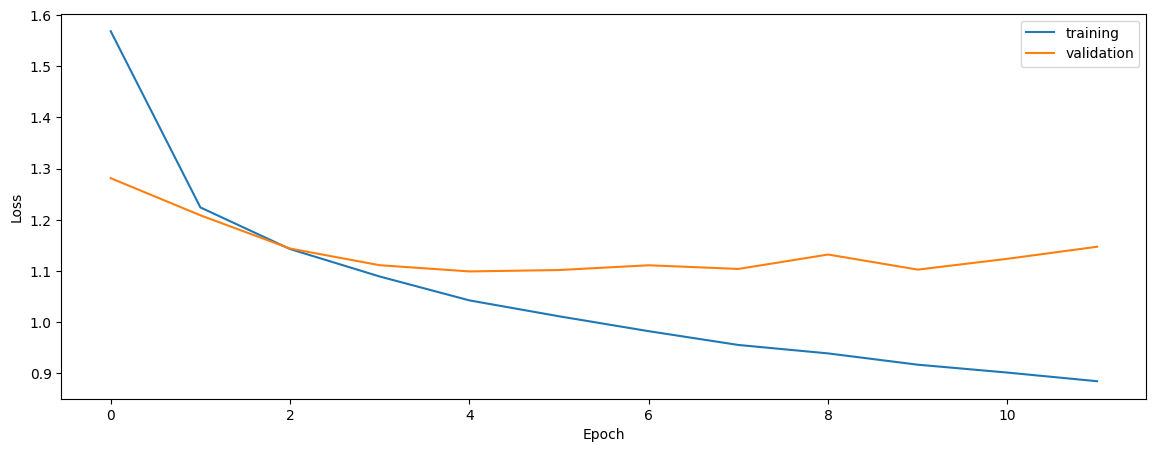

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6021819184799886
0.5628074255933152
0.5639176226214211


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.5739974326297226
0.5635647048899497
0.5229120966951936


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.5728224839371933
0.5535428369396532


0.5218196001291391


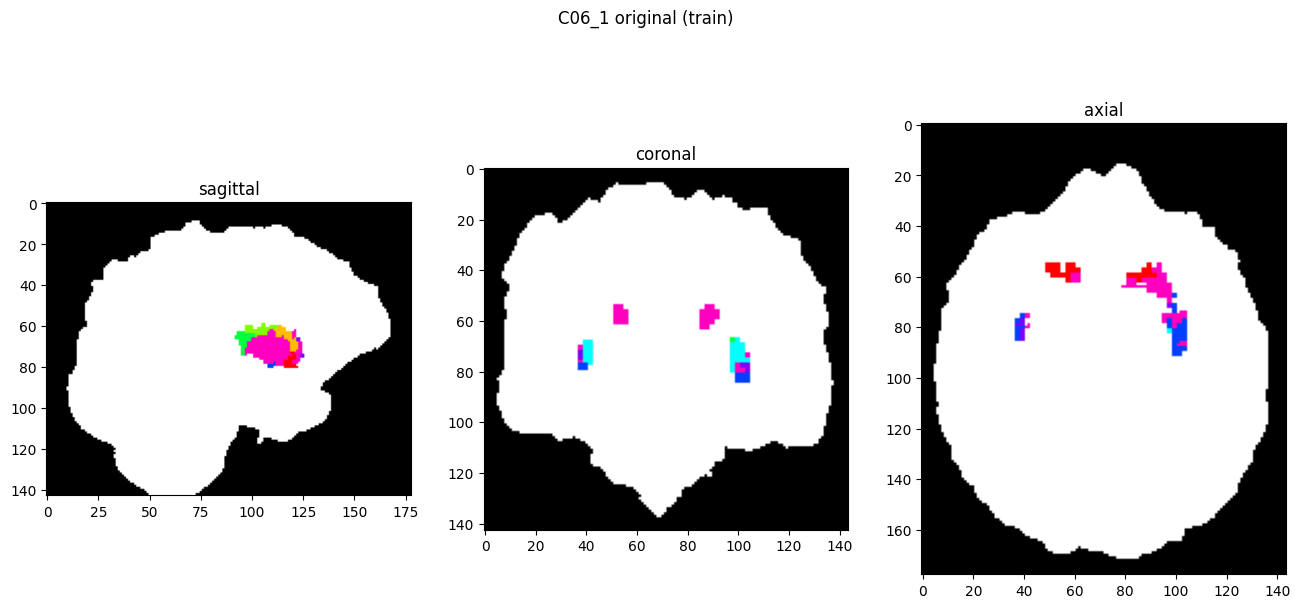

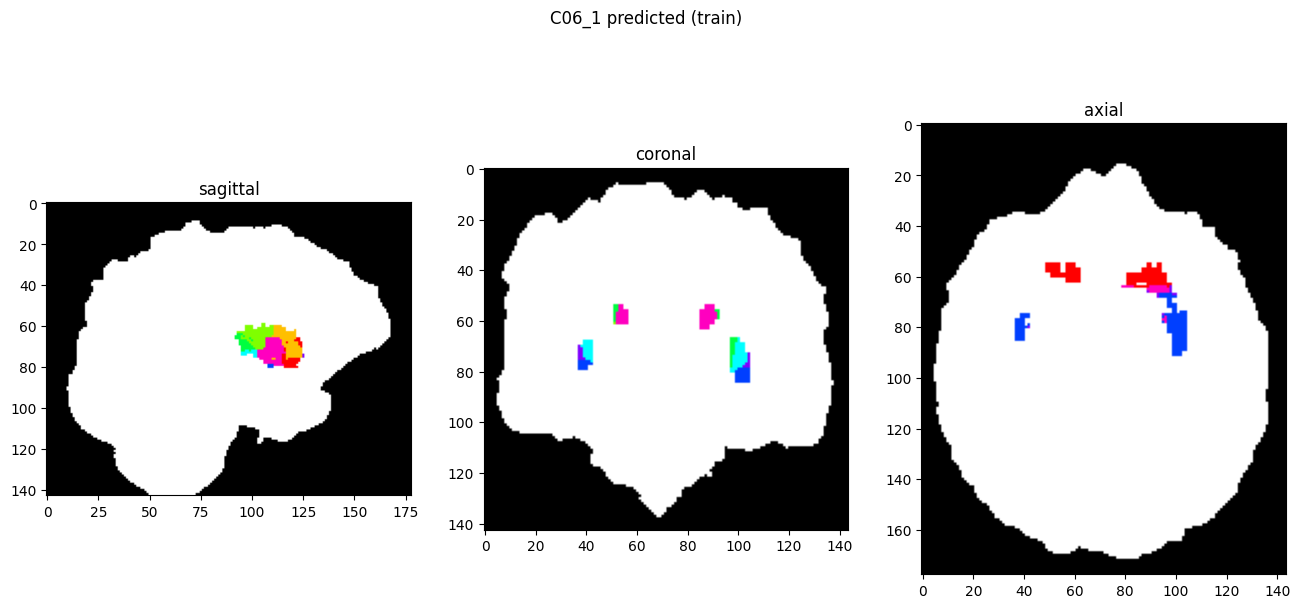

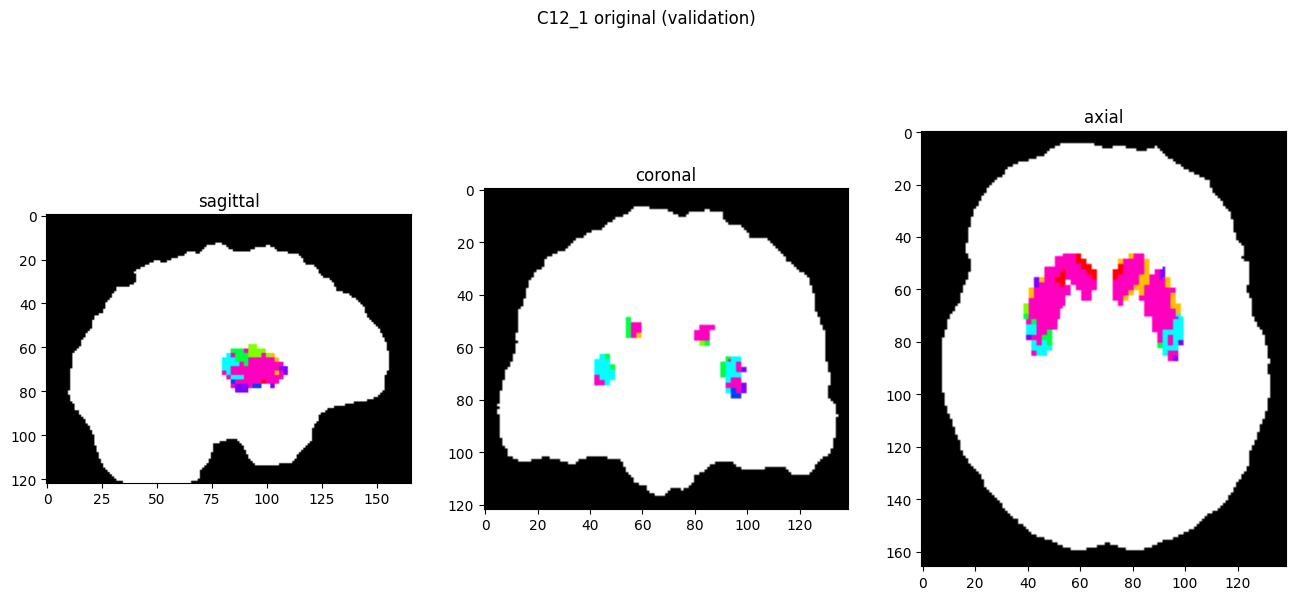

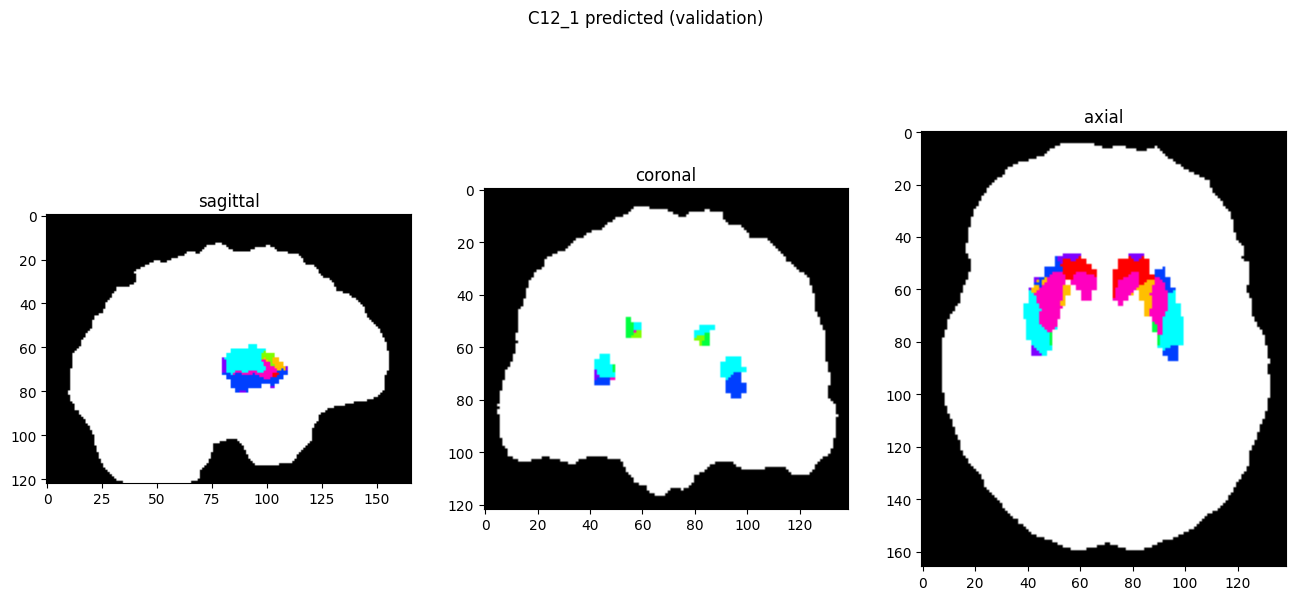

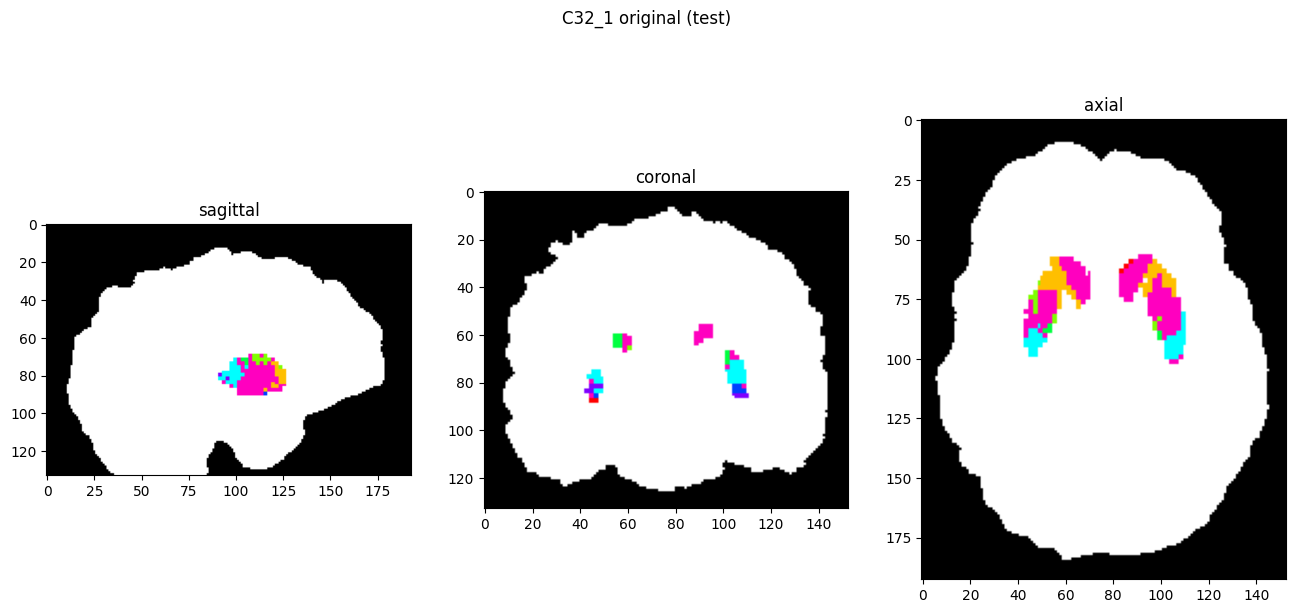

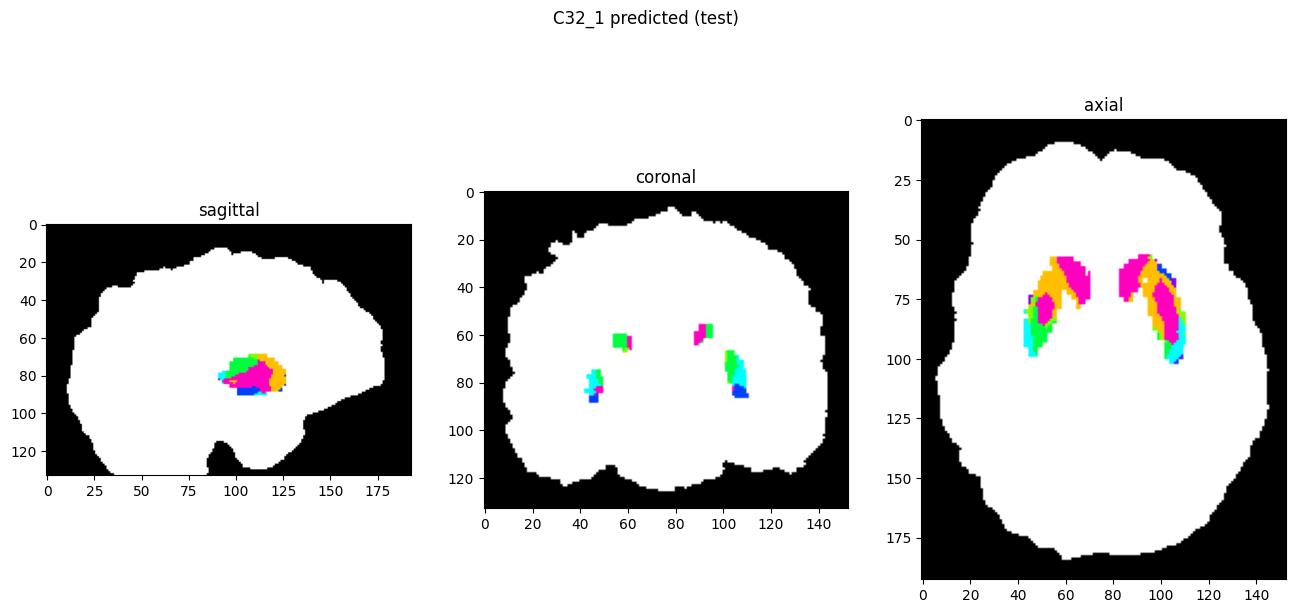

In [10]:
showResults(model, gen, threshold=0)